# 코랩 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# GPU 연결

In [ ]:
import torch

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_count = torch.cuda.device_count()
    device_name = torch.cuda.get_device_name(0)
    print(f'There are {device_count} GPU(s) available.')
    print(f'We will use the GPU:{device_name}')

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU:Tesla T4


# 데이터 불러오기(train)

In [ ]:
import pandas as pd

In [ ]:
train_input = pd.read_pickle("/content/drive/MyDrive/1_BERT code/data/v1/train_input.pickle")
train_output = pd.read_pickle("/content/drive/MyDrive/1_BERT code/data/v1/train_output.pickle")

In [ ]:
len(train_input)

560

In [ ]:
print("train input(context) :", len(train_input.values))
print("train output(label) :", len(train_output.values))

train input(context) : 560
train output(label) : 560


In [ ]:
contexts = train_input.values # numpy array로 변경
labels = train_output.values # numpy array로 변경

# Tokenize

## Tokenizer 불러오기(bert / kcbert)

In [ ]:
#bert
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
# tokenize 확인
print(' Original: ', contexts[0])

print('Tokenized: ', tokenizer.tokenize(contexts[0]))

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(contexts[0])))

 Original:  여야 진통 끝에 예비타당성예타 조사 면제 등의 조항을 담은 가덕도 신공항 특별법이 국회 국토교통위 소위를 통과했다 국회 국토위는 일 오후 법안심사소위를 열고 가덕도 신공항 특별법을 의결했다 법안에는 필요시 예타 면제 가능 사전타당성 조사 간소화 등의 조항이 담겼다 다만 환경영향평가는 면제하지 않고 실시하도록 명시됐다 막판까지 여야는 김해 신공항 폐지를 조항으로 명시하는지 여부를 두고 갈등을 벌였다 결국 여야는 조문에 명시하지 않고 부칙에 넣는데 합의를 했다 부칙은 국토부 장관이 가덕도 신공항의 위계 및 기능과 중복되는 내용이 없도록 제차 공항 종합계획을 수립한다는 내용이다 사실상 가덕도 신공항이 현재 추진 중인 김해신공항을 대체하는 공항이라는 점을 명문화한 셈이다 가덕도 신공항 특별법은 오는 일 법제사법위원회 의결을 거친 뒤 일 국회 본회의에서 처리될 전망이다
Tokenized:  ['여', '##야', '진', '##통', '끝', '##에', '예', '##비', '##타', '##당', '##성', '##예', '##타', '조', '##사', '면', '##제', '등의', '조', '##항', '##을', '담', '##은', '가', '##덕', '##도', '신', '##공', '##항', '특', '##별', '##법', '##이', '국', '##회', '국', '##토', '##교', '##통', '##위', '소', '##위를', '통', '##과', '##했다', '국', '##회', '국', '##토', '##위', '##는', '일', '오', '##후', '법', '##안', '##심', '##사', '##소', '##위를', '열', '##고', '가', '##덕', '##도', '신', '##공', '##항', '특', '##별', '##법을', '의', '##결', '##했다', '법', '##안', '##에는', '필', '##요', '##시', '예', '##타', '면', '##제', '가', '##능

In [ ]:
# 가장 긴 토큰 길이 확인(bert는 최대 512토큰 입력 가능)
max_len = 0

for context in contexts:

    # [CLS], [SEP] tokens 추가
    input_ids = tokenizer.encode(context, add_special_tokens=True)

    # 가장 긴 토큰 길이 찾기
    max_len = max(max_len, len(input_ids))

print('Max contexts length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (757 > 512). Running this sequence through the model will result in indexing errors


Max contexts length:  982


# train data 만들기

## train_input(contexts) 인코딩

In [ ]:
# 모든 contexts를 토큰화하고 해당 단어 ID에 매핑
input_ids = []
attention_masks = []

for context in contexts:

    encoded_dict = tokenizer.encode_plus(
                        context,                      # context를 인코당
                        add_special_tokens = True,    # [CLS], [SEP] token 추가
                        max_length = 64,              # 최대 문장 길이
                        pad_to_max_length = True,     # Pad & truncate
                        return_attention_mask = True, # 어텐션 마스크 추출
                        return_tensors = 'pt',        # pytorch tensor로 추출
                   )

    # 인코딩된 결과 중 input_ids를 리스트에 추가
    input_ids.append(encoded_dict['input_ids'])

    # 인코딩된 결과 중 attention_mask를 리스트에 추가
    attention_masks.append(encoded_dict['attention_mask'])

# 리스트를 텐서로 변환
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# 인코딩 확인
print('Original: ', contexts[0])

print('Token IDs:', input_ids[0])

print("Token IDs lenght :", len(input_ids[0]))

Original:  여야 진통 끝에 예비타당성예타 조사 면제 등의 조항을 담은 가덕도 신공항 특별법이 국회 국토교통위 소위를 통과했다 국회 국토위는 일 오후 법안심사소위를 열고 가덕도 신공항 특별법을 의결했다 법안에는 필요시 예타 면제 가능 사전타당성 조사 간소화 등의 조항이 담겼다 다만 환경영향평가는 면제하지 않고 실시하도록 명시됐다 막판까지 여야는 김해 신공항 폐지를 조항으로 명시하는지 여부를 두고 갈등을 벌였다 결국 여야는 조문에 명시하지 않고 부칙에 넣는데 합의를 했다 부칙은 국토부 장관이 가덕도 신공항의 위계 및 기능과 중복되는 내용이 없도록 제차 공항 종합계획을 수립한다는 내용이다 사실상 가덕도 신공항이 현재 추진 중인 김해신공항을 대체하는 공항이라는 점을 명문화한 셈이다 가덕도 신공항 특별법은 오는 일 법제사법위원회 의결을 거친 뒤 일 국회 본회의에서 처리될 전망이다
Token IDs: tensor([   101,   9565,  21711,   9708,  43022,   8977,  10530,   9576,  29455,
         22695,  21928,  17138,  96279,  22695,   9678,  12945,   9279,  17730,
         28697,   9678,  50632,  10622,   9064,  10892,   8843, 118782,  12092,
          9487,  28000,  50632,   9891,  61844,  33768,  10739,   8909,  14863,
          8909,  26444,  25242,  43022,  19855,   9448,  31166,   9879,  11882,
         12490,   8909,  14863,   8909,  26444,  19855,  11018,   9641,   9580,
         31531,   9341,  34951,  71013,  12945,  22333,  31166,   9

## Train Data(Train/valid) 나누기

In [ ]:
# torch.Tensor 타입의 데이터들을 사용해서 TensorDataset 구성
# trian, valid 데이터셋을 랜덤하게 split
from torch.utils.data import TensorDataset, random_split

In [ ]:
# TensorDataset에 결합
dataset = TensorDataset(input_ids, attention_masks, labels)

# 나눌 비율(9:1)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# 랜덤하게 섞어 나누기
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
print(f'train data : {train_size}')
print(f'validation data : {val_size}')

train data : 504
validation data : 56


## 데이터로더

In [ ]:
from torch.utils.data import DataLoader, SequentialSampler

In [ ]:
# 데이터로더에 배치사이즈 지정
batch_size = 32

In [ ]:
train_dataloader = DataLoader(
            train_dataset,
            shuffle=True,
            batch_size = batch_size
        )

In [ ]:
validation_dataloader = DataLoader(
            val_dataset,
            shuffle = True,
            batch_size = batch_size
        )

# 분류모델 불러오기

In [ ]:
# bert_base
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels = 7,
    output_attentions = False,
    output_hidden_states = False,
)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 모델 GPU로 이동
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

## 분류기 파라미터 구성 확인

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

# 학습 준비

## 옵티마이저 지정

In [ ]:
from transformers import AdamW

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 5e-5
                  eps = 1e-8 # 1e-8.
                )


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## epoch, scheduler 지정

In [ ]:
from transformers import get_linear_schedule_with_warmup

In [ ]:
epochs = 4

In [ ]:
total_steps = len(train_dataloader) * epochs

In [ ]:
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

## 학습에 필요한 기타 함수 생성

In [ ]:
import numpy as np

In [ ]:
# 예측값과 라벨을 활용하여 정확도를 계산하는 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

In [ ]:
# 학습 시간 알려주는 함수
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

In [ ]:
# seed 고정
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# 학습

In [ ]:
# Record all statistics from this epoch.
training_stats = []

# 시간 측정 시작
total_t0 = time.time()

# 학습 시작
for epoch_i in range(0, epochs):

    #train
    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print(f'  Batch {step}  of  {len(train_dataloader)}.    Elapsed: {elapsed}.')

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        a = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        loss = a["loss"]
        logits =a["logits"]

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print(f"  Average training loss: {avg_train_loss}")
    print(f"  Training epcoh took: {training_time}")

    # validation
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            b = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

            loss = b["loss"]
            logits = b["logits"]

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        total_eval_accuracy += flat_accuracy(logits, label_ids)


    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print(f"  Accuracy: {avg_val_accuracy}")

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print(f"  Validation Loss: {avg_val_loss}")
    print(f"  Validation took: {validation_time}")

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print(f"Total training took {format_time(time.time()-total_t0)} (h:mm:ss)")


======== Epoch 1 / 4 ========
Training...

  Average training loss: 1.920412503182888
  Training epcoh took: 0:00:06

Running Validation...
  Accuracy: 0.390625
  Validation Loss: 1.7878457307815552
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...

  Average training loss: 1.5918116495013237
  Training epcoh took: 0:00:05

Running Validation...
  Accuracy: 0.46354166666666663
  Validation Loss: 1.4525248408317566
  Validation took: 0:00:00

======== Epoch 3 / 4 ========
Training...

  Average training loss: 1.2828757464885712
  Training epcoh took: 0:00:05

Running Validation...
  Accuracy: 0.6197916666666667
  Validation Loss: 1.260651707649231
  Validation took: 0:00:00

======== Epoch 4 / 4 ========
Training...

  Average training loss: 1.1475307494401932
  Training epcoh took: 0:00:05

Running Validation...
  Accuracy: 0.6197916666666667
  Validation Loss: 1.2251835465431213
  Validation took: 0:00:00

Training complete!
Total training took 0:00:22 (h:mm:ss)


# 학습 결과 확인하기

In [ ]:
# 표
pd.set_option('display.precision',2)
df_result = pd.DataFrame(data=training_stats)
df_result = df_result.set_index('epoch')
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])
df_result

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.92,1.79,0.39,0:00:06,0:00:00
2,1.59,1.45,0.46,0:00:05,0:00:00
3,1.28,1.26,0.62,0:00:05,0:00:00
4,1.15,1.23,0.62,0:00:05,0:00:00


In [ ]:
df_result.to_excel("/content/drive/MyDrive/1_BERT code/results/bert_base/df_results.xlsx")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

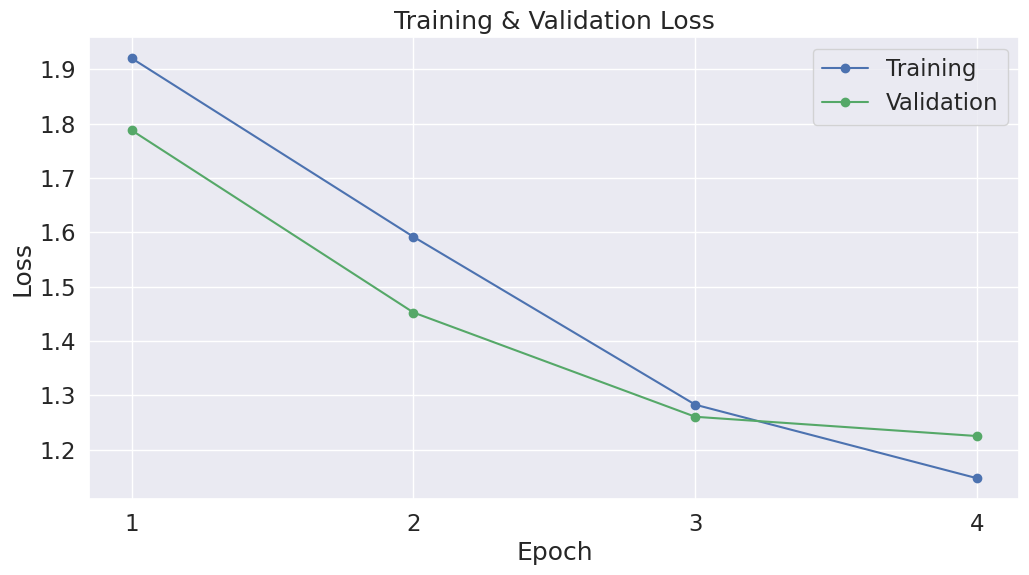

In [ ]:
# 그래프
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_result['Training Loss'], 'b-o', label="Training")
plt.plot(df_result['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.savefig("/content/drive/MyDrive/1_BERT code/results/bert_base/result.png")
plt.show()

# 테스트

# 테스트 데이터 셋

In [ ]:
test_input = pd.read_pickle("/content/drive/MyDrive/1_BERT code/data/v1/test_input.pickle")
test_output = pd.read_pickle("/content/drive/MyDrive/1_BERT code/data/v1/test_output.pickle")

In [ ]:
contexts = test_input.values
labels = test_output.values

## 테스트 데이터 인코딩

In [ ]:
input_ids = []
attention_masks = []

for context in contexts:
    encoded_dict = tokenizer.encode_plus(
                        context,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )

    input_ids.append(encoded_dict['input_ids'])

    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
batch_size = 32

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_dataloader = DataLoader(prediction_data, shuffle=False, batch_size=batch_size)

In [ ]:
print(f'Predicting labels for {len(input_ids)} test sentences...')

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('DONE')

Predicting labels for 140 test sentences...
DONE


In [ ]:
flat_predictions = np.argmax(np.concatenate(predictions, axis=0), axis=1)
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the accuracy
accuracy = np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)
print('Accuracy:', accuracy)

Accuracy: 0.6428571428571429


# Test 결과값 txt로 저장

In [ ]:
import os

In [ ]:
test_text = f"test accuracy : {accuracy}"

In [ ]:
print(test_text)

test accuracy : 0.6428571428571429


In [ ]:
file_path = "/content/drive/MyDrive/1_BERT code/results/bert_base/test_result_bert.txt"

In [ ]:
directory = os.path.dirname(file_path)

In [ ]:
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
with open(file_path, 'w') as file:
    file.write(test_text)